In [ ]:
!pip install numpy matplotlib

In [ ]:
!pip install pandas tqdm


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
import torch
torch.__version__

'2.5.1+cu124'

In [44]:
import inspect
from collections import defaultdict
import pandas as pd
from torch.utils import benchmark 

pd.options.display.precision = 3

def var_dict(*args):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return dict([(name, val) for name, val in callers_local_vars if val is arg][0] 
                for arg in args)

def walltime(stmt, arg_dict, duration=10):
    return benchmark.Timer(stmt=stmt, globals=arg_dict).blocked_autorange(
        min_run_time=duration).median

In [45]:
from collections import defaultdict
# dict of dict
from tqdm import tqdm
matmul_tflops = defaultdict(lambda: {})
for n in tqdm([128, 512, 2*1024, 4*1024, 8*1024, 16*1024, 32*1024]):
    for dtype in (torch.float32, torch.float16):
        a = torch.randn(n, n, dtype=dtype).cuda()
        b = torch.randn(n, n, dtype=dtype).cuda()   
        t = walltime('a @ b', var_dict(a, b))
        matmul_tflops[f'n={n}'][dtype] = 2*n**3 / t / 1e12
        del a, b
        
pd.DataFrame(matmul_tflops)

100%|██████████| 7/7 [03:22<00:00, 28.87s/it]


,n=128,n=512,n=2048,n=4096,n=8192,n=16384,n=32768
torch.float32,0.970,21.673,47.221,48.103,50.798,47.085,46.165
torch.float16,0.994,44.046,140.260,148.991,145.076,144.044,142.136


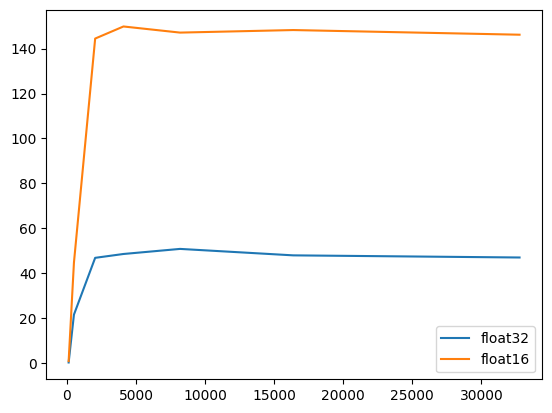

In [18]:
xs = [128, 512, 2*1024, 4*1024, 8*1024, 16*1024, 32*1024]
plt.plot(xs, list(map(lambda x:matmul_tflops[f'n={x}'][torch.float32],xs)))
plt.plot(xs, list(map(lambda x:matmul_tflops[f'n={x}'][torch.float16],xs)))
plt.legend(['float32','float16'])

|GPU Model|	Memory Bandwidth|	Memory Type|
|-|-|-|
|RTX 4090|	1,008 GB/s|	GDDR6X (24GB)|
|RTX 4080|	716.8 GB/s|	GDDR6X (16GB)|
|RTX 3090|	936.2 GB/s|	GDDR6X (24GB)|
|RTX 3080 Ti|	616.0 GB/s|	GDDR6X (12GB)|
|RTX 6000 Ada|	1,008 GB/s|	GDDR6X (48GB)|
|A100|	1,555 GB/s|	HBM2 (40GB)|

In [46]:
vector = defaultdict(lambda:{})
for n in tqdm([1024*64, 1024*256, 1024*1024, 1024*4096]):
    a = torch.randn(n).cuda()
    t = walltime('a * 1.2', var_dict(a))
    vector[n]['TFLOPS'] = n / t / 1e12
    vector[n]['GB/s'] = 8 * n / t / 1e9
pd.DataFrame(vector)

100%|██████████| 4/4 [00:41<00:00, 10.40s/it]


,65536,262144,1048576,4194304
TFLOPS,0.025,0.103,0.298,0.437
GB/s,197.989,821.384,2385.732,3492.814


In [28]:
import os

os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'
os.environ['SOCKS_PROXY'] = 'http://127.0.0.1:7890'

In [37]:
from transformers import BertModel, BertTokenizer
from transformers import AutoConfig
from transformers.models.bert.modeling_bert import BertLayer

model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
config = AutoConfig.from_pretrained('bert-base-uncased')

# Example input
inputs = tokenizer("Hello, world!", return_tensors="pt")

# Get the output hidden states
outputs = model(**inputs)
hidden_states = outputs.last_hidden_state
hidden_states,config.hidden_size

(tensor([[[-0.0781,  0.1587,  0.0400,  ..., -0.2805,  0.0248,  0.4081],
          [-0.2016,  0.1781,  0.4184,  ..., -0.2522,  0.3630, -0.0979],
          [-0.7156,  0.6751,  0.6017,  ..., -1.1032,  0.0797,  0.0567],
          [ 0.0527, -0.1483,  1.3609,  ..., -0.4513,  0.1274,  0.2655],
          [-0.7122, -0.4815, -0.1438,  ...,  0.5602, -0.1062, -0.1301],
          [ 0.9955,  0.1328, -0.0621,  ...,  0.2460, -0.6502, -0.3296]]],
        grad_fn=<NativeLayerNormBackward0>),
 768)

In [38]:
layer = BertLayer(config).half().cuda()

In [29]:
def layer_benchmark(layer, hidden_size, seq_lens, batch_sizes, cross_attention=False):
    h = hidden_size
    results = defaultdict(lambda: {})    
    encoder_state = 'encoder_hidden_states=X' if cross_attention else ''
    for s in seq_lens:
        for b in batch_sizes:            
            ffn = 16*b*s*h*h / 1e12  # TFLOPs for the Feed-Forward Network
            atten = (4*b*h*s*s + 8*b*s*h*h) / 1e12  # TFLOPs for attention            
            forward = ffn + (2 if cross_attention else 1) * atten
            
            X = torch.randn(b, s, h).half().cuda()
            results[f'batch={b}'][f'fwd seq_len={s}'] = forward / walltime(
                f'layer(X, {encoder_state})', var_dict(layer, X))
            results[f'batch={b}'][f'fwd+bwd seq_len={s}'] = 3 * forward / walltime(
                f'layer(X, {encoder_state})[0].sum().backward()', var_dict(layer, X))            
    return pd.DataFrame(results)

In [36]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [39]:
layer_benchmark(layer, config.hidden_size, [128, 512], [2, 4, 8, 16, 32, 64, 128])

,batch=2,batch=4,batch=8,batch=16,batch=32,batch=64,batch=128
fwd seq_len=128,17.439,35.468,69.536,81.586,85.312,85.408,79.884
fwd+bwd seq_len=128,18.331,36.994,69.019,84.058,90.447,94.509,86.173
fwd seq_len=512,63.555,65.196,57.201,55.317,54.807,53.140,52.928
fwd+bwd seq_len=512,61.315,68.291,62.284,62.498,60.989,59.735,59.620


In [40]:
# ffn 中的其中一层 mlp, h=>4h
layer.intermediate.dense

Linear(in_features=768, out_features=3072, bias=True)

In [41]:
h, b, s = config.hidden_size, 64, 128
X = torch.randn(b, s, h).half().cuda()

'Dense layer TFLOPS: %.3f' % (8*b*s*h*h / 1e12 / walltime(    
    'layer.intermediate.dense(X)', var_dict(layer, X)))

'Dense layer TFLOPS: 141.782'

In [42]:
layer.intermediate

BertIntermediate(
  (dense): Linear(in_features=768, out_features=3072, bias=True)
  (intermediate_act_fn): GELUActivation()
)

In [43]:
from transformers.models.gpt2.modeling_gpt2 import GPT2Block

config = AutoConfig.from_pretrained("gpt2-medium")
layer = GPT2Block(config, layer_idx=0).half().cuda()
layer_benchmark(layer, config.n_embd, [512, 1024], [2, 4, 8, 16, 32, 64])

,batch=2,batch=4,batch=8,batch=16,batch=32,batch=64
fwd seq_len=512,65.886,65.551,50.604,45.259,43.649,43.005
fwd+bwd seq_len=512,66.138,65.252,53.993,49.567,48.884,48.524
fwd seq_len=1024,41.033,39.592,35.900,34.737,36.159,36.129
fwd+bwd seq_len=1024,44.848,43.445,40.566,41.411,39.909,41.549
